<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Networks)

- GAN : https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 64.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M/

## 2. Import python libraries and define util functions

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(g_loss, d_loss, title=None):

    plt.plot(g_loss)
    plt.plot(d_loss)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Generator Loss', 'Discriminator Loss'], loc=0)
    # plt.show()

In [3]:
set_seed(0)

## 3. Check dataset

In [4]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [5]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X = []  # initialize empty lists for storing images

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    return X_train, X_test

X_train, X_test = get_data()  # load data set (no y label needed as we only need images) / unsupervised learning

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1600, 1, 56, 56)
X_test.shape = (400, 1, 56, 56)


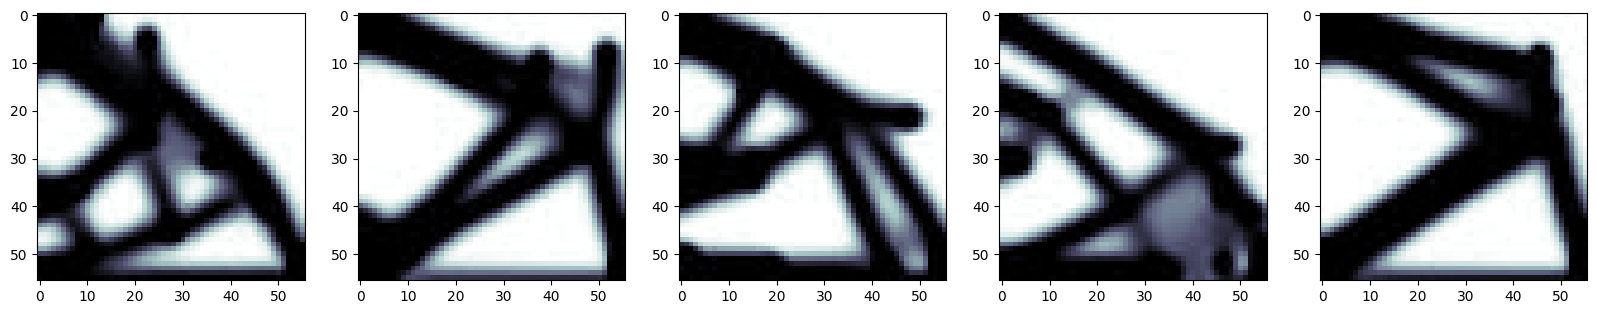

In [6]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
plt.show()

## 5. Set to model architecture

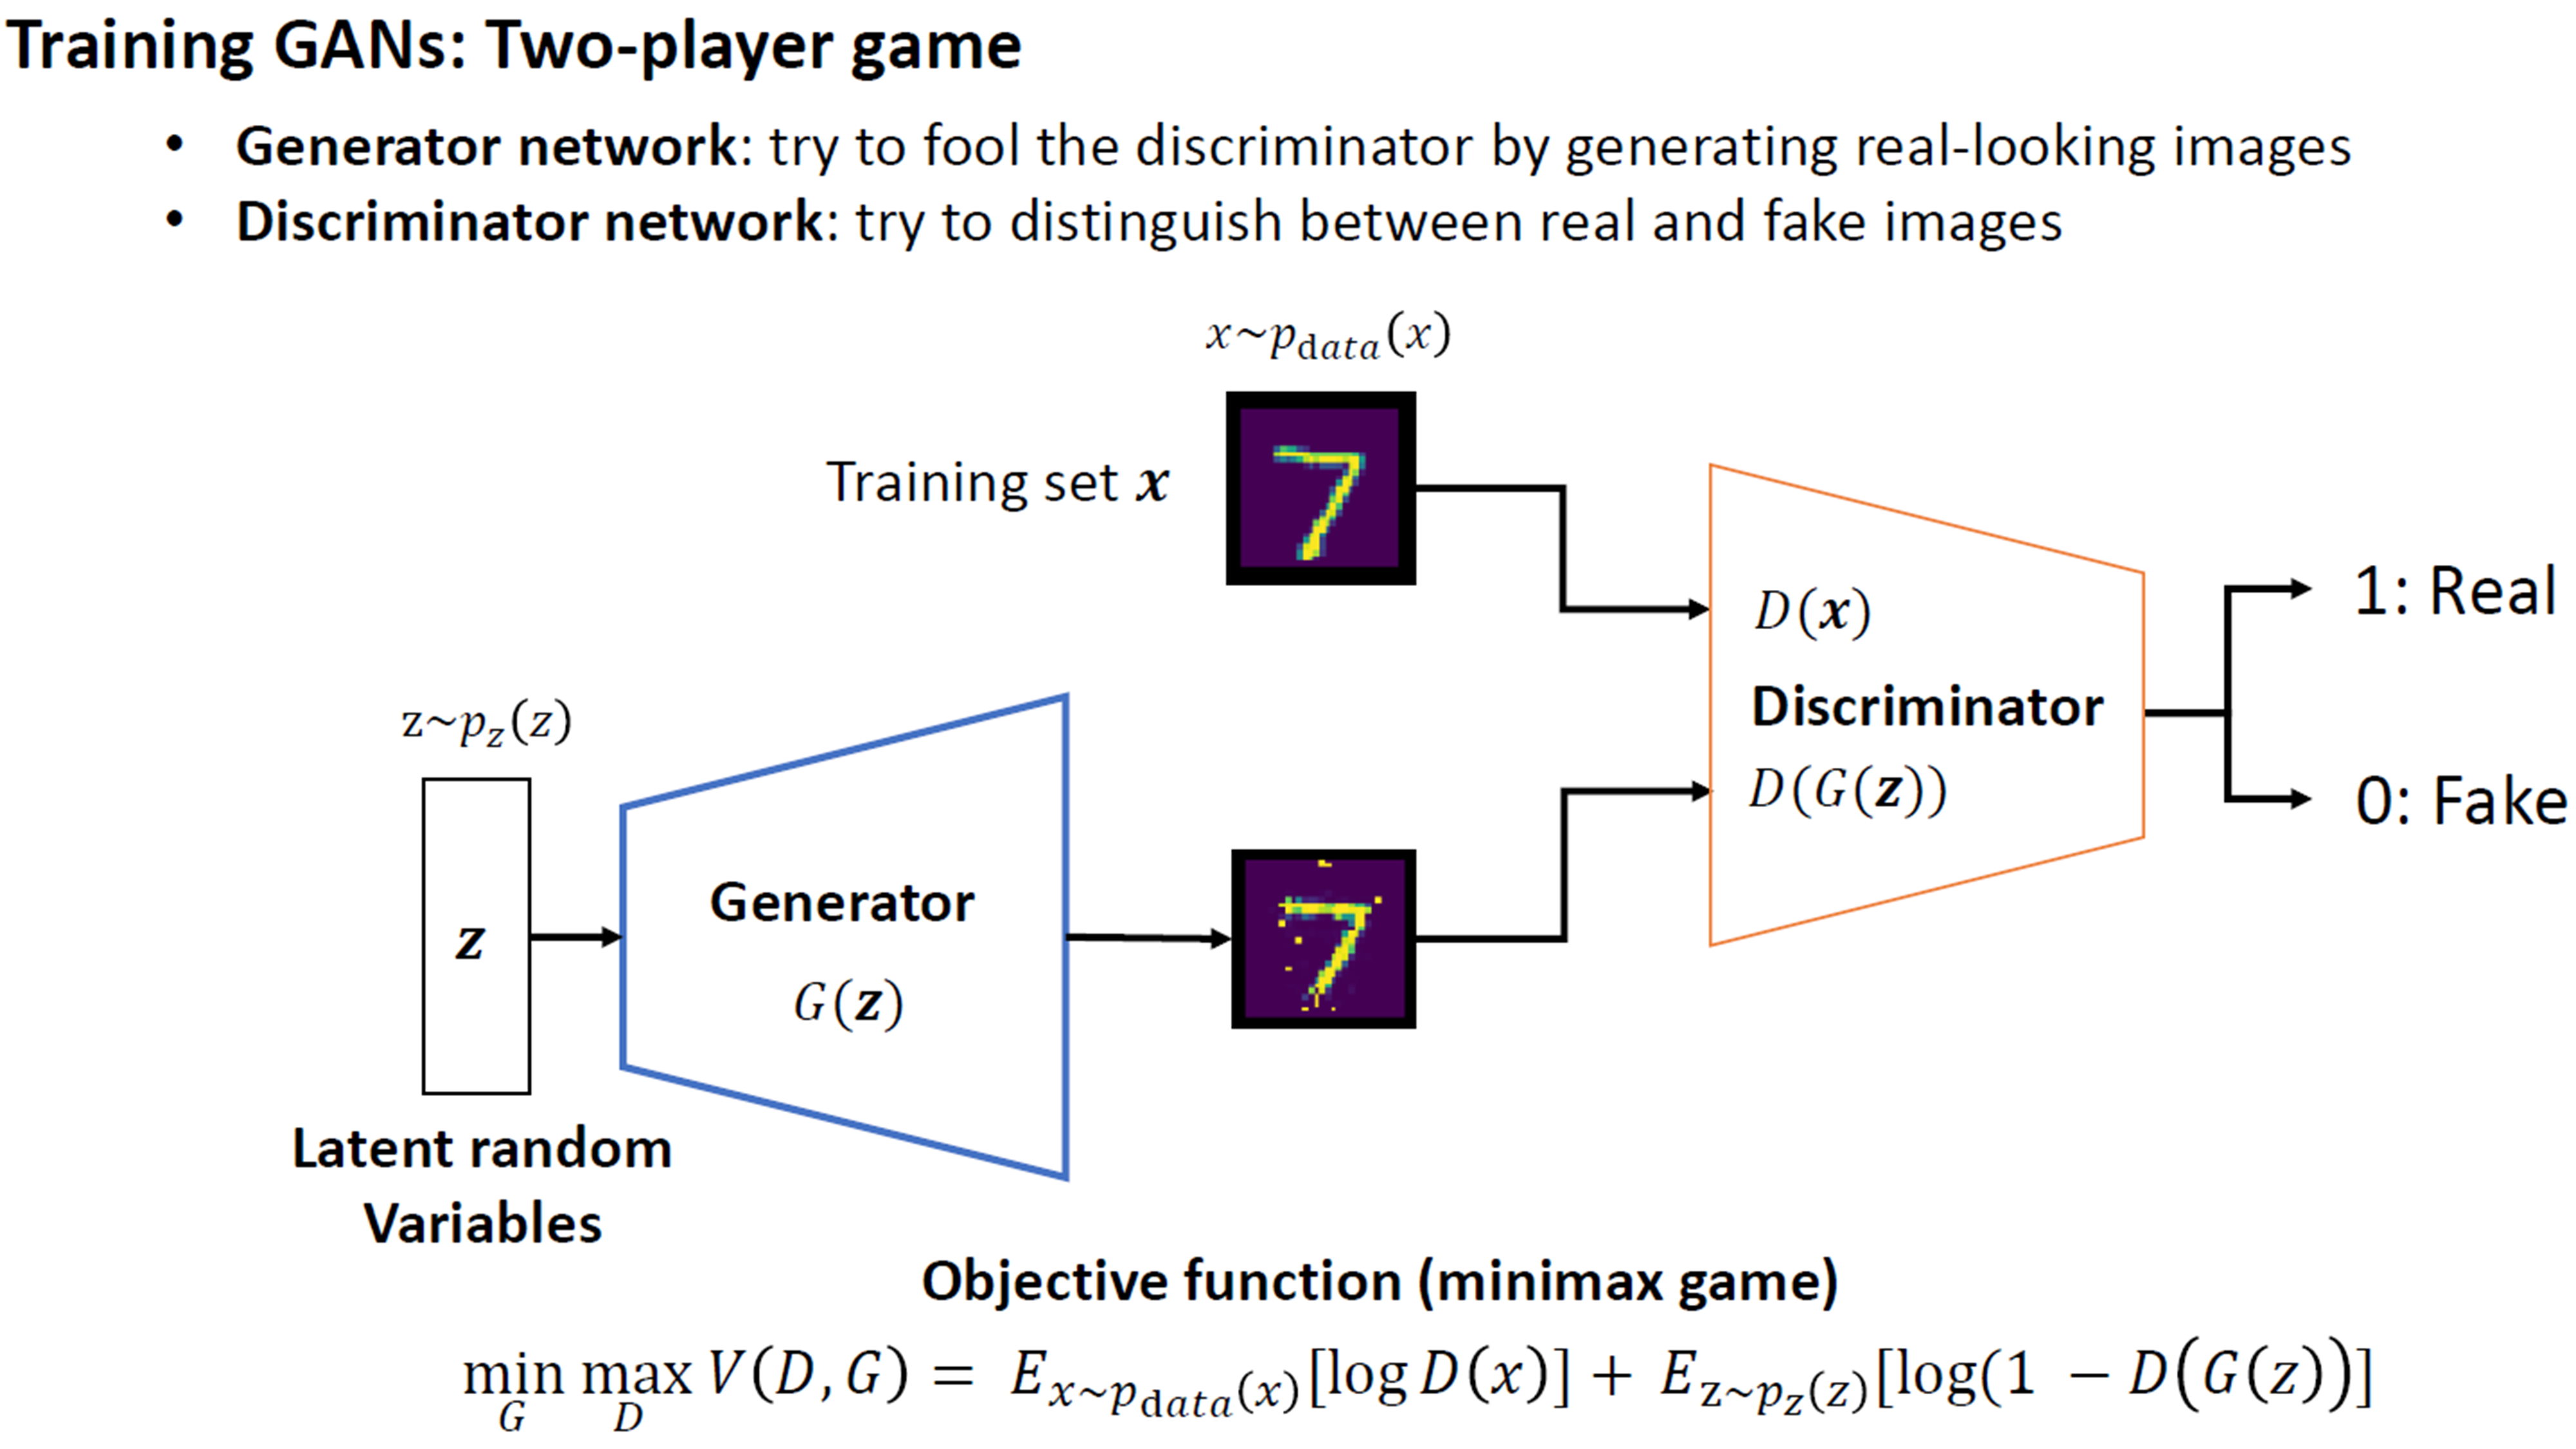

In [7]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, x):
        gen = self.generator(x)

        return gen

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, x):
        dis = self.discriminator(x)

        return dis

## 6. Set model hyperparameters

In [8]:
# model architecture parameters
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 784
noise_size = 100

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 500

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

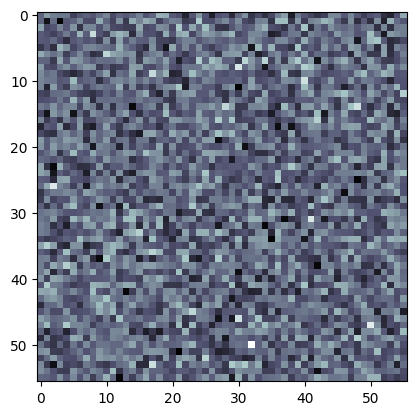

In [9]:
# define networks and set to device (GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
test_images = torch.tensor(X_test, dtype=torch.float32).to(device)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# check generated fake bracket image
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)

# lists to track training and validation history
g_loss_history = []  # generator loss history
d_loss_history = []  # discriminator loss history

In [10]:
# define fixed noise for visualization
fixed_noise = torch.randn(10, noise_size).to(device)  # 10 fixed noise vectors

# create a directory to save generated images
os.makedirs("./GAN_samples/", exist_ok=True)

Epoch [1/500]  D Loss: 0.5163  G Loss: 0.8278


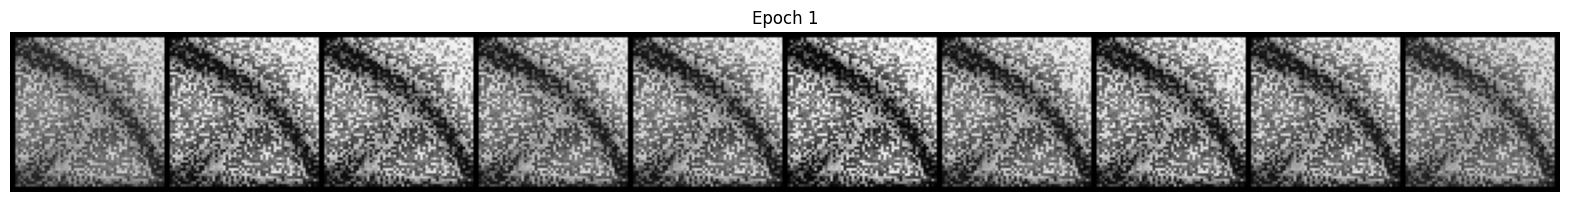

Epoch [2/500]  D Loss: 0.1389  G Loss: 1.7841
Epoch [3/500]  D Loss: 0.0959  G Loss: 2.0097
Epoch [4/500]  D Loss: 0.1168  G Loss: 3.0335
Epoch [5/500]  D Loss: 0.2924  G Loss: 2.2897
Epoch [6/500]  D Loss: 0.2301  G Loss: 2.1271
Epoch [7/500]  D Loss: 0.2443  G Loss: 2.4365
Epoch [8/500]  D Loss: 0.1795  G Loss: 2.9332
Epoch [9/500]  D Loss: 0.1193  G Loss: 2.9877
Epoch [10/500]  D Loss: 0.1528  G Loss: 3.2895
Epoch [11/500]  D Loss: 0.2282  G Loss: 2.4478
Epoch [12/500]  D Loss: 0.1556  G Loss: 2.3032
Epoch [13/500]  D Loss: 0.0933  G Loss: 4.5081
Epoch [14/500]  D Loss: 0.0553  G Loss: 5.3429
Epoch [15/500]  D Loss: 0.0566  G Loss: 4.4425
Epoch [16/500]  D Loss: 0.0592  G Loss: 3.8973
Epoch [17/500]  D Loss: 0.0467  G Loss: 4.0313
Epoch [18/500]  D Loss: 0.0243  G Loss: 4.5050
Epoch [19/500]  D Loss: 0.0667  G Loss: 3.6096
Epoch [20/500]  D Loss: 0.0209  G Loss: 4.3678
Epoch [21/500]  D Loss: 0.0396  G Loss: 4.2394
Epoch [22/500]  D Loss: 0.0331  G Loss: 4.5570
Epoch [23/500]  D Los

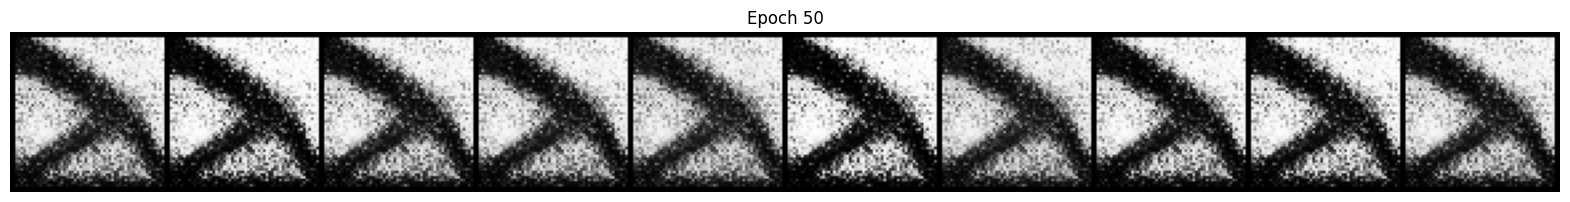

Epoch [51/500]  D Loss: 0.0781  G Loss: 5.8376
Epoch [52/500]  D Loss: 0.0274  G Loss: 6.1783
Epoch [53/500]  D Loss: 0.0466  G Loss: 6.8277
Epoch [54/500]  D Loss: 0.0673  G Loss: 5.2594
Epoch [55/500]  D Loss: 0.0464  G Loss: 4.6768
Epoch [56/500]  D Loss: 0.0657  G Loss: 5.6199
Epoch [57/500]  D Loss: 0.0937  G Loss: 3.7809
Epoch [58/500]  D Loss: 0.0347  G Loss: 5.2148
Epoch [59/500]  D Loss: 0.0584  G Loss: 6.5407
Epoch [60/500]  D Loss: 0.0548  G Loss: 5.9775
Epoch [61/500]  D Loss: 0.1124  G Loss: 5.6478
Epoch [62/500]  D Loss: 0.0784  G Loss: 4.7650
Epoch [63/500]  D Loss: 0.0547  G Loss: 4.7574
Epoch [64/500]  D Loss: 0.0286  G Loss: 5.5625
Epoch [65/500]  D Loss: 0.0329  G Loss: 6.4571
Epoch [66/500]  D Loss: 0.0952  G Loss: 5.3050
Epoch [67/500]  D Loss: 0.0557  G Loss: 5.5756
Epoch [68/500]  D Loss: 0.0618  G Loss: 6.0805
Epoch [69/500]  D Loss: 0.0604  G Loss: 5.5048
Epoch [70/500]  D Loss: 0.0986  G Loss: 4.7221
Epoch [71/500]  D Loss: 0.0495  G Loss: 5.2826
Epoch [72/500

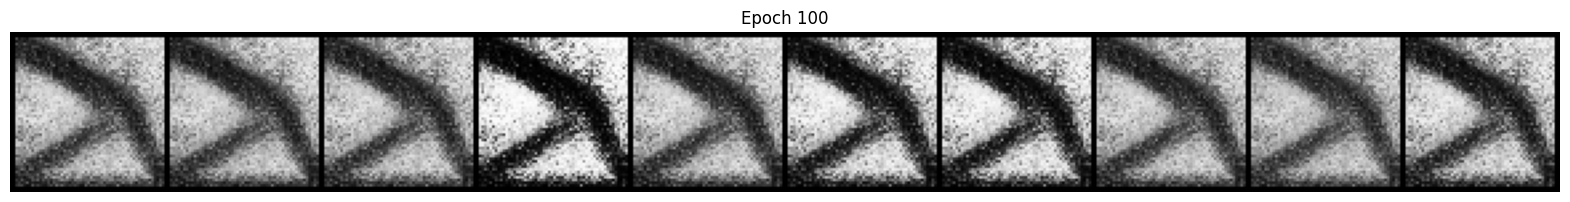

Epoch [101/500]  D Loss: 0.0629  G Loss: 4.6749
Epoch [102/500]  D Loss: 0.0455  G Loss: 5.5590
Epoch [103/500]  D Loss: 0.0504  G Loss: 5.4865
Epoch [104/500]  D Loss: 0.0744  G Loss: 4.6255
Epoch [105/500]  D Loss: 0.0429  G Loss: 4.7090
Epoch [106/500]  D Loss: 0.0426  G Loss: 5.8360
Epoch [107/500]  D Loss: 0.0373  G Loss: 4.4476
Epoch [108/500]  D Loss: 0.0625  G Loss: 4.1785
Epoch [109/500]  D Loss: 0.0346  G Loss: 5.6265
Epoch [110/500]  D Loss: 0.0673  G Loss: 6.5043
Epoch [111/500]  D Loss: 0.0769  G Loss: 4.8299
Epoch [112/500]  D Loss: 0.0777  G Loss: 5.5758
Epoch [113/500]  D Loss: 0.0796  G Loss: 4.6097
Epoch [114/500]  D Loss: 0.0704  G Loss: 4.3736
Epoch [115/500]  D Loss: 0.0632  G Loss: 4.8527
Epoch [116/500]  D Loss: 0.1115  G Loss: 4.1192
Epoch [117/500]  D Loss: 0.1172  G Loss: 4.7000
Epoch [118/500]  D Loss: 0.0680  G Loss: 4.1086
Epoch [119/500]  D Loss: 0.0415  G Loss: 4.6886
Epoch [120/500]  D Loss: 0.0519  G Loss: 4.9384
Epoch [121/500]  D Loss: 0.0707  G Loss:

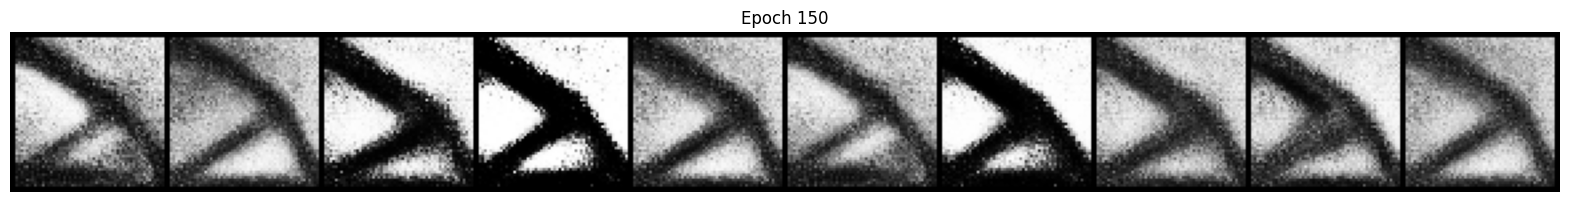

Epoch [151/500]  D Loss: 0.0831  G Loss: 4.4182
Epoch [152/500]  D Loss: 0.0765  G Loss: 4.4992
Epoch [153/500]  D Loss: 0.1291  G Loss: 4.3890
Epoch [154/500]  D Loss: 0.0816  G Loss: 4.6453
Epoch [155/500]  D Loss: 0.1058  G Loss: 4.1535
Epoch [156/500]  D Loss: 0.0953  G Loss: 4.4586
Epoch [157/500]  D Loss: 0.0879  G Loss: 4.0085
Epoch [158/500]  D Loss: 0.1021  G Loss: 4.4624
Epoch [159/500]  D Loss: 0.0874  G Loss: 4.2459
Epoch [160/500]  D Loss: 0.1388  G Loss: 4.8279
Epoch [161/500]  D Loss: 0.1178  G Loss: 4.0825
Epoch [162/500]  D Loss: 0.1253  G Loss: 3.9775
Epoch [163/500]  D Loss: 0.1195  G Loss: 3.7653
Epoch [164/500]  D Loss: 0.1224  G Loss: 4.2743
Epoch [165/500]  D Loss: 0.1337  G Loss: 4.4058
Epoch [166/500]  D Loss: 0.1095  G Loss: 4.1854
Epoch [167/500]  D Loss: 0.1250  G Loss: 4.1832
Epoch [168/500]  D Loss: 0.1347  G Loss: 3.6261
Epoch [169/500]  D Loss: 0.1311  G Loss: 4.1738
Epoch [170/500]  D Loss: 0.1369  G Loss: 3.9099
Epoch [171/500]  D Loss: 0.1206  G Loss:

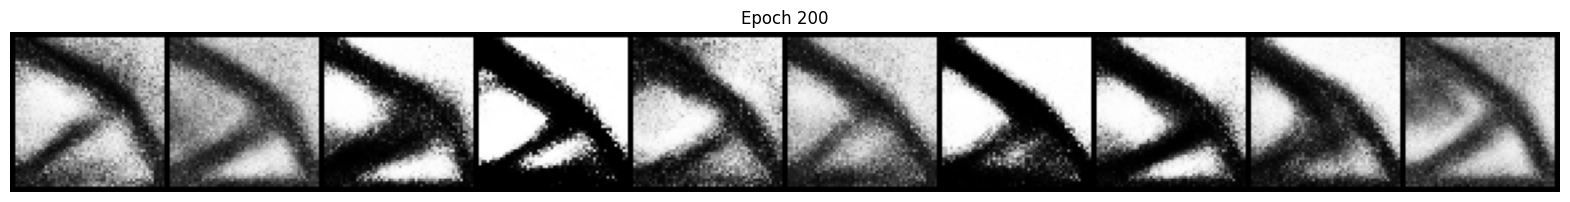

Epoch [201/500]  D Loss: 0.1486  G Loss: 3.4815
Epoch [202/500]  D Loss: 0.1597  G Loss: 3.9056
Epoch [203/500]  D Loss: 0.1732  G Loss: 3.4775
Epoch [204/500]  D Loss: 0.1397  G Loss: 3.6022
Epoch [205/500]  D Loss: 0.1522  G Loss: 3.7531
Epoch [206/500]  D Loss: 0.1204  G Loss: 3.7629
Epoch [207/500]  D Loss: 0.1657  G Loss: 3.6729
Epoch [208/500]  D Loss: 0.1442  G Loss: 3.5908
Epoch [209/500]  D Loss: 0.1386  G Loss: 3.7803
Epoch [210/500]  D Loss: 0.1230  G Loss: 3.9576
Epoch [211/500]  D Loss: 0.1229  G Loss: 4.0472
Epoch [212/500]  D Loss: 0.1225  G Loss: 4.0910
Epoch [213/500]  D Loss: 0.1230  G Loss: 4.0484
Epoch [214/500]  D Loss: 0.1366  G Loss: 3.8936
Epoch [215/500]  D Loss: 0.1293  G Loss: 3.9848
Epoch [216/500]  D Loss: 0.1107  G Loss: 3.8053
Epoch [217/500]  D Loss: 0.1242  G Loss: 4.1238
Epoch [218/500]  D Loss: 0.1259  G Loss: 3.8862
Epoch [219/500]  D Loss: 0.1244  G Loss: 4.1192
Epoch [220/500]  D Loss: 0.1313  G Loss: 4.1594
Epoch [221/500]  D Loss: 0.1838  G Loss:

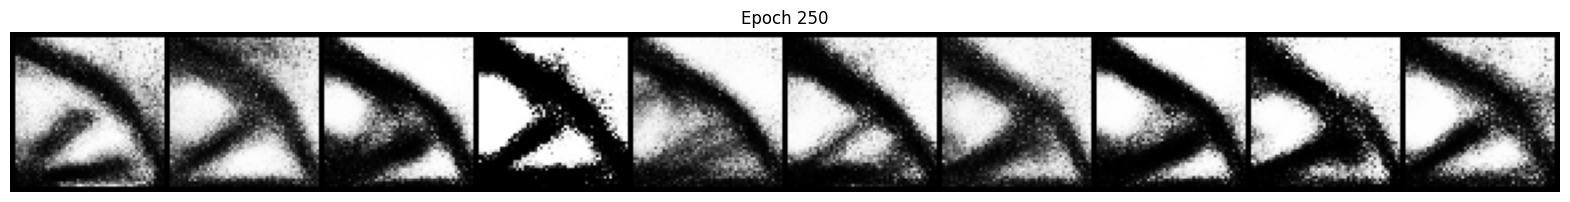

Epoch [251/500]  D Loss: 0.1822  G Loss: 3.8093
Epoch [252/500]  D Loss: 0.1130  G Loss: 3.9375
Epoch [253/500]  D Loss: 0.1698  G Loss: 3.5235
Epoch [254/500]  D Loss: 0.1492  G Loss: 3.6878
Epoch [255/500]  D Loss: 0.1765  G Loss: 3.4100
Epoch [256/500]  D Loss: 0.1498  G Loss: 3.6293
Epoch [257/500]  D Loss: 0.1495  G Loss: 3.7346
Epoch [258/500]  D Loss: 0.1666  G Loss: 3.6246
Epoch [259/500]  D Loss: 0.1482  G Loss: 3.6701
Epoch [260/500]  D Loss: 0.1579  G Loss: 3.7905
Epoch [261/500]  D Loss: 0.1701  G Loss: 3.4262
Epoch [262/500]  D Loss: 0.1837  G Loss: 3.4814
Epoch [263/500]  D Loss: 0.1751  G Loss: 3.3301
Epoch [264/500]  D Loss: 0.1762  G Loss: 3.5466
Epoch [265/500]  D Loss: 0.2027  G Loss: 3.2106
Epoch [266/500]  D Loss: 0.1563  G Loss: 3.4014
Epoch [267/500]  D Loss: 0.1885  G Loss: 3.1914
Epoch [268/500]  D Loss: 0.1782  G Loss: 3.2374
Epoch [269/500]  D Loss: 0.1473  G Loss: 3.5651
Epoch [270/500]  D Loss: 0.1772  G Loss: 3.5036
Epoch [271/500]  D Loss: 0.1767  G Loss:

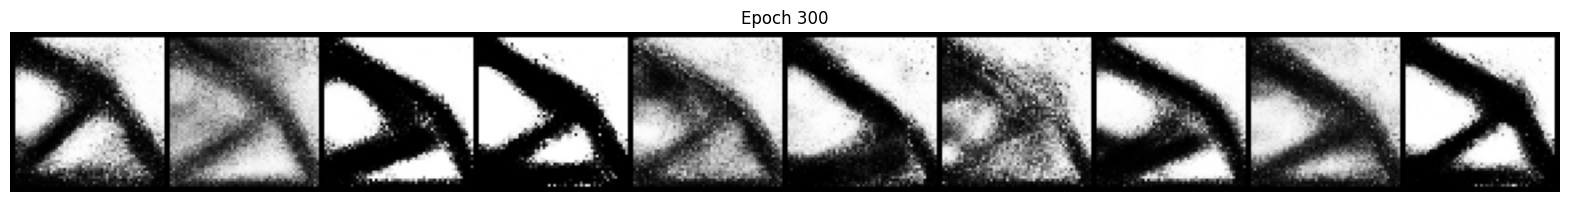

Epoch [301/500]  D Loss: 0.1698  G Loss: 3.3482
Epoch [302/500]  D Loss: 0.1376  G Loss: 3.6071
Epoch [303/500]  D Loss: 0.1511  G Loss: 3.7638
Epoch [304/500]  D Loss: 0.1533  G Loss: 3.5616
Epoch [305/500]  D Loss: 0.1669  G Loss: 3.7697
Epoch [306/500]  D Loss: 0.1638  G Loss: 3.7134
Epoch [307/500]  D Loss: 0.1842  G Loss: 3.5792
Epoch [308/500]  D Loss: 0.1602  G Loss: 3.4976
Epoch [309/500]  D Loss: 0.1729  G Loss: 3.3769
Epoch [310/500]  D Loss: 0.2074  G Loss: 3.2948
Epoch [311/500]  D Loss: 0.1918  G Loss: 3.3522
Epoch [312/500]  D Loss: 0.1547  G Loss: 3.5892
Epoch [313/500]  D Loss: 0.1657  G Loss: 3.5416
Epoch [314/500]  D Loss: 0.1856  G Loss: 3.3743
Epoch [315/500]  D Loss: 0.1678  G Loss: 3.2041
Epoch [316/500]  D Loss: 0.1714  G Loss: 3.3632
Epoch [317/500]  D Loss: 0.1832  G Loss: 3.5726
Epoch [318/500]  D Loss: 0.1969  G Loss: 3.0845
Epoch [319/500]  D Loss: 0.1653  G Loss: 3.3111
Epoch [320/500]  D Loss: 0.1375  G Loss: 3.4608
Epoch [321/500]  D Loss: 0.1880  G Loss:

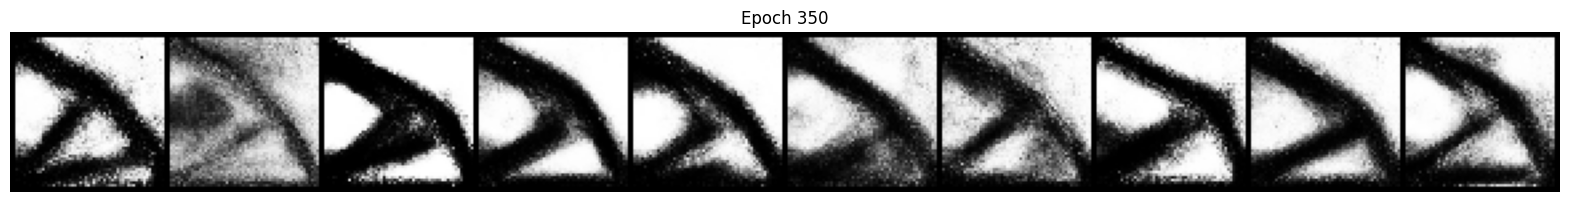

Epoch [351/500]  D Loss: 0.1829  G Loss: 3.2782
Epoch [352/500]  D Loss: 0.2447  G Loss: 2.9444
Epoch [353/500]  D Loss: 0.1984  G Loss: 3.0905
Epoch [354/500]  D Loss: 0.2096  G Loss: 3.1934
Epoch [355/500]  D Loss: 0.2303  G Loss: 2.9697
Epoch [356/500]  D Loss: 0.1999  G Loss: 3.0612
Epoch [357/500]  D Loss: 0.2056  G Loss: 2.9486
Epoch [358/500]  D Loss: 0.1932  G Loss: 3.1939
Epoch [359/500]  D Loss: 0.1900  G Loss: 3.3234
Epoch [360/500]  D Loss: 0.2137  G Loss: 3.1120
Epoch [361/500]  D Loss: 0.2154  G Loss: 3.0083
Epoch [362/500]  D Loss: 0.2095  G Loss: 2.9871
Epoch [363/500]  D Loss: 0.1880  G Loss: 3.3054
Epoch [364/500]  D Loss: 0.2077  G Loss: 3.0256
Epoch [365/500]  D Loss: 0.2396  G Loss: 2.8748
Epoch [366/500]  D Loss: 0.1706  G Loss: 3.0904
Epoch [367/500]  D Loss: 0.1970  G Loss: 3.2527
Epoch [368/500]  D Loss: 0.2227  G Loss: 2.9652
Epoch [369/500]  D Loss: 0.1895  G Loss: 3.1205
Epoch [370/500]  D Loss: 0.2183  G Loss: 3.1352
Epoch [371/500]  D Loss: 0.2589  G Loss:

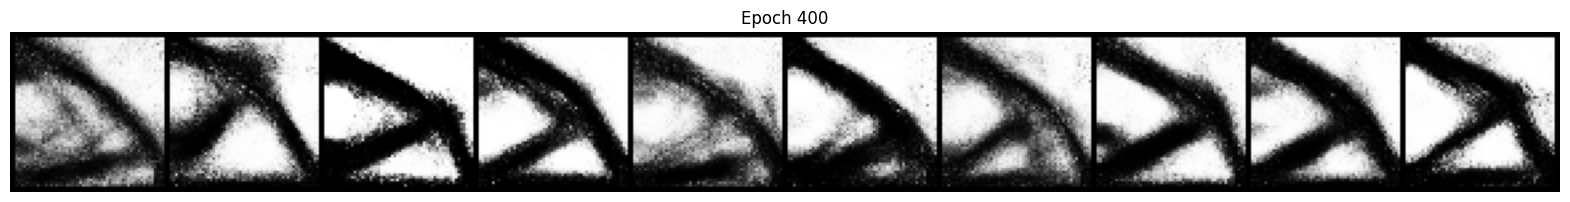

Epoch [401/500]  D Loss: 0.2536  G Loss: 2.8966
Epoch [402/500]  D Loss: 0.2360  G Loss: 2.6960
Epoch [403/500]  D Loss: 0.2408  G Loss: 3.0275
Epoch [404/500]  D Loss: 0.2313  G Loss: 2.9629
Epoch [405/500]  D Loss: 0.2186  G Loss: 2.7533
Epoch [406/500]  D Loss: 0.1764  G Loss: 3.1804
Epoch [407/500]  D Loss: 0.2044  G Loss: 3.1325
Epoch [408/500]  D Loss: 0.2393  G Loss: 2.9601
Epoch [409/500]  D Loss: 0.2139  G Loss: 3.0324
Epoch [410/500]  D Loss: 0.2227  G Loss: 3.3707
Epoch [411/500]  D Loss: 0.2299  G Loss: 2.7068
Epoch [412/500]  D Loss: 0.2142  G Loss: 2.9901
Epoch [413/500]  D Loss: 0.1937  G Loss: 3.1480
Epoch [414/500]  D Loss: 0.2424  G Loss: 3.0254
Epoch [415/500]  D Loss: 0.2301  G Loss: 2.7793
Epoch [416/500]  D Loss: 0.1960  G Loss: 3.1579
Epoch [417/500]  D Loss: 0.2070  G Loss: 3.1911
Epoch [418/500]  D Loss: 0.2194  G Loss: 3.0763
Epoch [419/500]  D Loss: 0.1998  G Loss: 2.9815
Epoch [420/500]  D Loss: 0.2327  G Loss: 3.1545
Epoch [421/500]  D Loss: 0.1936  G Loss:

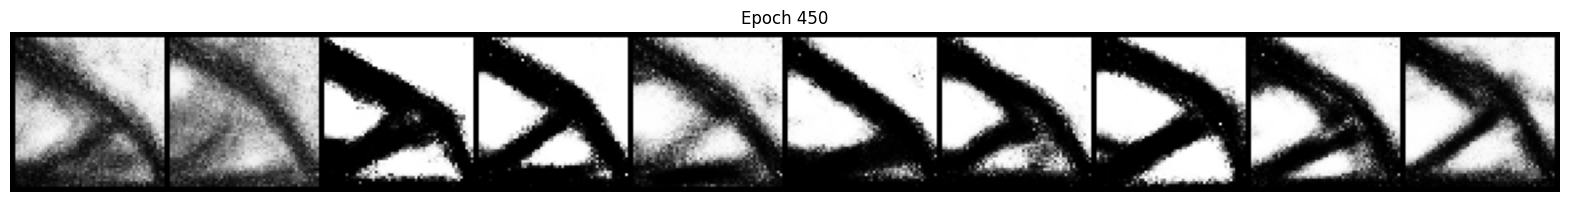

Epoch [451/500]  D Loss: 0.2125  G Loss: 3.0496
Epoch [452/500]  D Loss: 0.2020  G Loss: 3.0650
Epoch [453/500]  D Loss: 0.1955  G Loss: 3.2177
Epoch [454/500]  D Loss: 0.2107  G Loss: 3.0428
Epoch [455/500]  D Loss: 0.2362  G Loss: 3.0981
Epoch [456/500]  D Loss: 0.2230  G Loss: 3.1004
Epoch [457/500]  D Loss: 0.2038  G Loss: 3.0455
Epoch [458/500]  D Loss: 0.1985  G Loss: 3.2715
Epoch [459/500]  D Loss: 0.2177  G Loss: 3.0933
Epoch [460/500]  D Loss: 0.2230  G Loss: 2.9027
Epoch [461/500]  D Loss: 0.2301  G Loss: 3.1084
Epoch [462/500]  D Loss: 0.1939  G Loss: 3.4548
Epoch [463/500]  D Loss: 0.1843  G Loss: 3.2579
Epoch [464/500]  D Loss: 0.2016  G Loss: 3.1091
Epoch [465/500]  D Loss: 0.2388  G Loss: 2.9242
Epoch [466/500]  D Loss: 0.2067  G Loss: 3.1166
Epoch [467/500]  D Loss: 0.1922  G Loss: 3.3243
Epoch [468/500]  D Loss: 0.1947  G Loss: 3.3122
Epoch [469/500]  D Loss: 0.2445  G Loss: 3.0050
Epoch [470/500]  D Loss: 0.2388  G Loss: 3.0721
Epoch [471/500]  D Loss: 0.2291  G Loss:

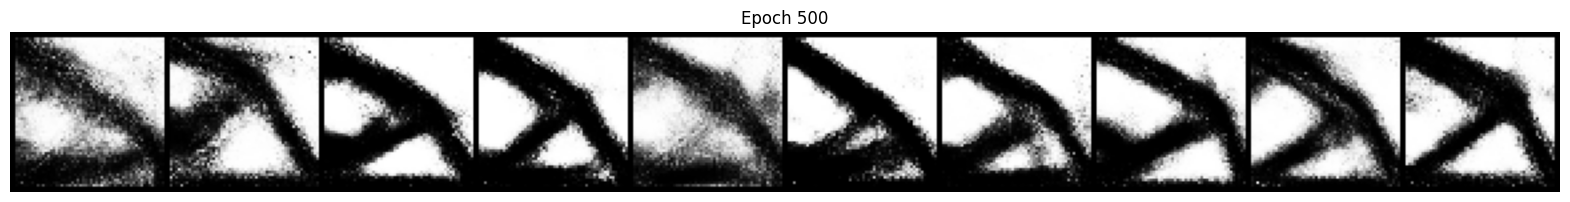

In [11]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    total_g_loss = 0.0  # initialize total generator loss for the epoch
    total_d_loss = 0.0  # initialize total discriminator loss for the epoch

    for i, (images) in enumerate(train_loader):

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_images = images[0].reshape(batch_size, -1)  # flatten image to (batch_size, 56*56)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_images), real_label)

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # accumulate g_loss
        total_g_loss += g_loss.item()

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        d_optimizer.zero_grad()

        # calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_images.detach()), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        d_loss = (fake_loss + real_loss)/2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

        # accumulate d_loss
        total_d_loss += d_loss.item()

    # calculate average losses for the epoch
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)

    # save the average loss for this epoch
    g_loss_history.append(avg_g_loss)
    d_loss_history.append(avg_d_loss)

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {avg_d_loss:.4f}  G Loss: {avg_g_loss:.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 50 == 0 or epoch == 1:
        with torch.no_grad():
            # generate fake images with fixed noise
            fake_images = generator(fixed_noise).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./GAN_samples/GAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./GAN_samples/GAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./GAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./GAN_samples/discriminator_epoch_{epoch}.pth")

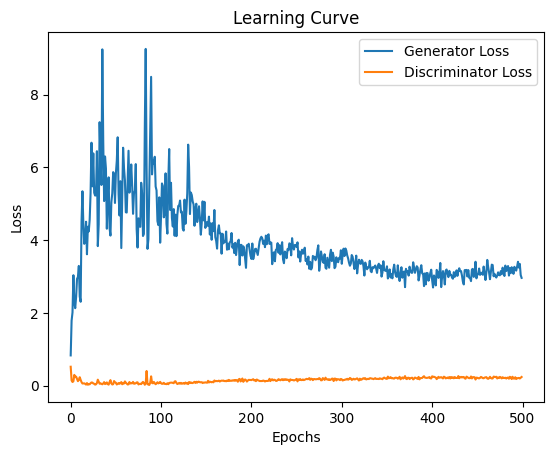

In [12]:
# graph visualization
plot_loss(g_loss_history, d_loss_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 8. Load & Evaluate model

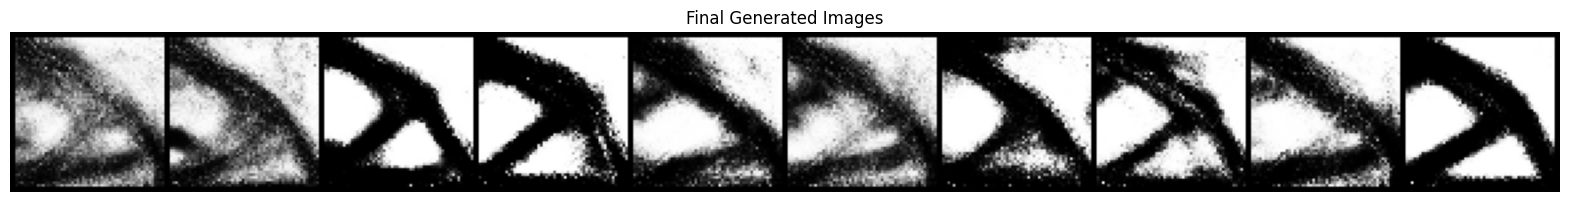

In [18]:
# final Image Generation and Visualization after training
with torch.no_grad():
    final_noise = torch.randn(10, noise_size).to(device)
    final_fake_images = generator(final_noise).cpu()
    final_fake_images = final_fake_images.view(-1, 1, 56, 56)
    save_image(final_fake_images, f"./GAN_samples/GAN_final.png", nrow=10, normalize=True)

# display the final generated images
plt.figure(figsize=(20, 4))
img = plt.imread("./GAN_samples/GAN_final.png")
plt.imshow(img)
plt.title("Final Generated Images")
plt.axis('off')
plt.show()